In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta  # Technical Analysis library

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Attention, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Time-Series-Forecasting

## 1. Initial Data Loading and Cleaning

The historical Bitcoin price data were downloaded from the **Coinbase API**. The dataset contains the price data for **1 year**, from **January 2024** to **January 2025**.

In [2]:
btc_price_data_1_year = pd.read_csv("data/bitcoin_historical_data_1_year.csv")
btc_price_data_1_year

,timestamp,open,high,low,close,volume
0,2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
1,2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2,2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
3,2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
4,2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...,...
527180,2025-01-23 23:56:00,104047.01,104112.45,104064.68,104079.63,6.922352
527181,2025-01-23 23:57:00,104052.01,104088.97,104079.63,104079.60,1.628341
527182,2025-01-23 23:58:00,103928.31,104088.89,104079.60,103964.62,10.861781
527183,2025-01-23 23:59:00,103900.00,103973.87,103964.62,103926.36,6.802193


In [3]:
btc_price_data_1_year = btc_price_data_1_year[:10000]
btc_price_data_1_year

,timestamp,open,high,low,close,volume
0,2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
1,2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2,2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
3,2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
4,2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...,...
9995,2024-01-31 22:02:00,42420.16,42451.00,42425.24,42451.00,7.068808
9996,2024-01-31 22:03:00,42427.79,42456.86,42446.18,42430.09,4.379217
9997,2024-01-31 22:04:00,42402.66,42432.58,42427.77,42408.60,2.724979
9998,2024-01-31 22:05:00,42407.00,42459.21,42409.95,42454.19,4.449828


In [4]:
def load_and_clean_data(df):
    # Convert timestamp to datetime if it isn't already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set timestamp as index
    df.set_index('timestamp', inplace=True, drop = True)
    
    # Sort by timestamp to ensure proper order
    df = df.sort_index()
    
    # Check for and handle any missing values
    df = df.dropna()
    
    return df

In [5]:
btc_price_data_1_year = load_and_clean_data(btc_price_data_1_year)

C:\Users\valch\AppData\Local\Temp\ipykernel_10716\3549922966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])


In [6]:
btc_price_data_1_year

,open,high,low,close,volume
timestamp,,,,,
2024-01-25 00:00:00,40051.20,40079.88,40079.87,40051.80,6.601578
2024-01-25 00:01:00,40041.00,40070.32,40051.60,40061.92,7.541910
2024-01-25 00:02:00,40038.13,40068.79,40061.59,40042.82,7.078218
2024-01-25 00:03:00,40043.36,40056.15,40043.36,40055.80,1.614071
2024-01-25 00:04:00,40052.64,40063.21,40056.15,40063.20,1.924187
...,...,...,...,...,...
2024-01-31 22:02:00,42420.16,42451.00,42425.24,42451.00,7.068808
2024-01-31 22:03:00,42427.79,42456.86,42446.18,42430.09,4.379217
2024-01-31 22:04:00,42402.66,42432.58,42427.77,42408.60,2.724979


In [7]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,10000.0,41937.756808,1176.398866,39503.000000,41600.060000,42101.955000,42910.862500,43779.560000
high,10000.0,41965.215445,1178.875617,39544.660000,41625.325000,42119.255000,42936.222500,43872.990000
low,10000.0,41951.433600,1177.610554,39533.470000,41613.905000,42111.565000,42923.575000,43843.600000
close,10000.0,41951.829143,1177.500059,39533.480000,41615.880000,42111.355000,42923.060000,43850.580000
volume,10000.0,8.445071,14.580559,0.042391,1.516104,3.361168,8.535135,299.323667


In [8]:
btc_price_data_1_year.dtypes

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object

In [9]:
btc_price_data_1_year.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### 1.2. Plot Bitcoin Price

In [10]:
def plot_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    x_lim_start = dates[0]
    x_lim_end = dates[len(dates) - 1]
    # plt.xlim(x_lim_start, x_lim_end)
    ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates, prices)
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.show()

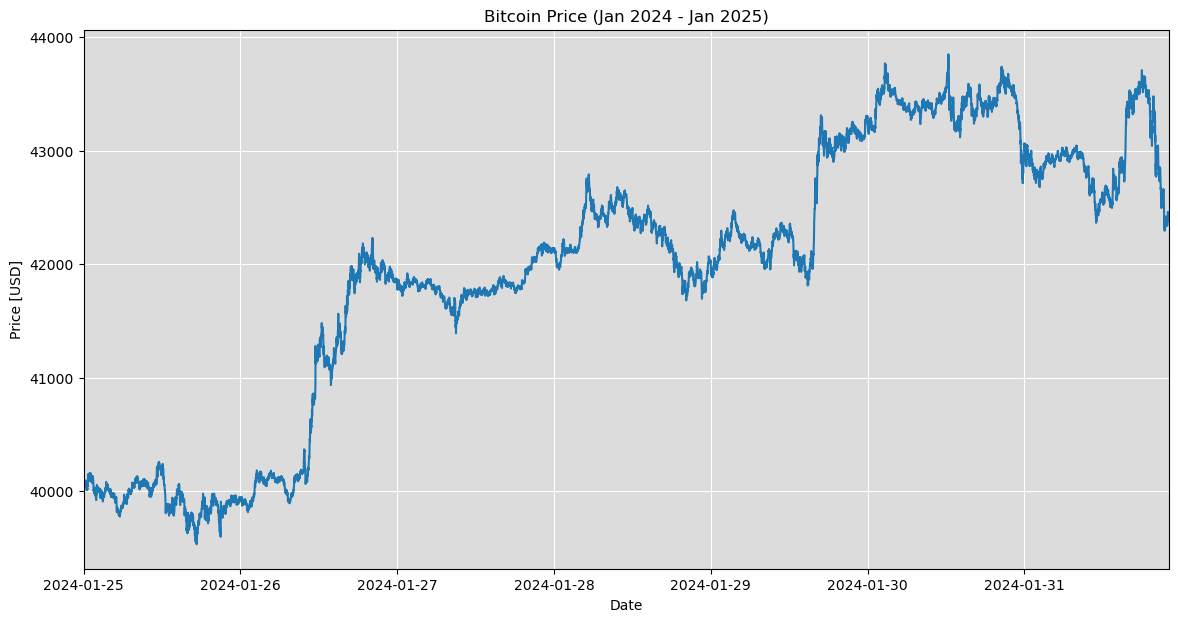

In [11]:
dates = btc_price_data_1_year.index
prices_close_btc = btc_price_data_1_year.close
title_btc = 'Bitcoin Price (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_market_data(dates, prices_close_btc, labels, title_btc)

## 2. Feature Engineering

### 2.1. Calculate Technical Indicators

In [12]:
def add_technical_indicators(df):
    # Copy the dataframe to avoid modifying the original
    df = df.copy()
    
    # Basic price indicators
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close']/df['close'].shift(1))
    
    # Volume indicators
    df['volume_ma'] = df['volume'].rolling(window=24).mean()  # 24-hour moving average
    df['volume_std'] = df['volume'].rolling(window=24).std()
    
    # Trend indicators
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_20'] = df['close'].ewm(span=20).mean()
    
    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close']).rsi()
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(df['close'])
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_mid'] = bollinger.bollinger_mavg()
    
    return df

In [13]:
btc_price_data_1_year = add_technical_indicators(btc_price_data_1_year)

In [14]:
btc_price_data_1_year.describe().T

,count,mean,std,min,25%,50%,75%,max
open,10000.0,41937.756808,1176.398866,39503.000000,41600.060000,42101.955000,42910.862500,43779.560000
high,10000.0,41965.215445,1178.875617,39544.660000,41625.325000,42119.255000,42936.222500,43872.990000
low,10000.0,41951.433600,1177.610554,39533.470000,41613.905000,42111.565000,42923.575000,43843.600000
close,10000.0,41951.829143,1177.500059,39533.480000,41615.880000,42111.355000,42923.060000,43850.580000
volume,10000.0,8.445071,14.580559,0.042391,1.516104,3.361168,8.535135,299.323667
returns,9999.0,0.000006,0.000545,-0.004260,-0.000259,0.000003,0.000265,0.007984
log_returns,9999.0,0.000006,0.000545,-0.004269,-0.000259,0.000003,0.000265,0.007952
volume_ma,9977.0,8.449421,10.535376,0.626881,2.502218,4.102344,9.642253,73.702226
volume_std,9977.0,6.755064,7.800856,0.411530,2.098824,3.594439,8.222606,64.018045
sma_20,9981.0,41953.184673,1176.375698,39594.162500,41613.017500,42115.279500,42929.157500,43695.193000


### 2.2. Add Time-Based Features

We extract various components of the datetime, such as the **month**, **day_of_month**, **hour**, and **day_of_week**. This can help the model capture seasonality and trends.

For time-based features like **hour** and **day_of_week**, we can use **cyclical encoding**. This ensures that values like 23:00 and 00:00 are considered "close" to each other, rather than being far apart numerically.

In [15]:
def add_temporal_features(df):
    df = df.copy()
    
    # Extract time components
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.weekday
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month
    
    # Create cyclical features for time components
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)  # Hour sin encoding
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)  # Hour cos encoding
    df['day_of_week_sin'] = np.sin(2 * np.pi * df.index.weekday / 7)  # Weekday sin encoding
    df['day_of_week_cos'] = np.cos(2 * np.pi * df.index.weekday / 7)  # Weekday cos encoding
    
    return df

In [16]:
btc_price_data_1_year = add_temporal_features(btc_price_data_1_year)

In [17]:
# btc_price_data_1_year[['hour', 'day_of_week', 'day_of_month', 'month']][300000:300050]

### 2.3. Seasonality and Trends

#### 2.3.1. STL (Seasonal-Trend decomposition using LOESS)

**STL** stands for **Seasonal-Trend decomposition using LOESS**. It's a robust statistical method used to decompose a time series into three components:

1. **Seasonal Component**: Represents the repeating pattern in the data over a fixed period (e.g., daily, weekly, monthly).
2. **Trend Component**: Captures the long-term progression in the data, showing an overall increase, decrease, or stability over time.
3. **Remainder/Residual Component**: Represents the part of the data that cannot be attributed to either seasonality or trend, often considered as noise.

**Key Features of STL**
- **Flexible**: Allows decomposition of time series with any type of seasonal pattern, not limited to a fixed frequency.
- **Robust**: Resistant to outliers in the data.
- **Local Regression (LOESS)**: Uses locally weighted regression to smooth the data during decomposition.

**Applications**
- **Forecasting**: By isolating the trend and seasonal components, forecasting models can be more accurate.
- **Anomaly Detection**: The remainder component helps identify unusual spikes or dips.
- **Visualization**: Simplifies understanding of the data by breaking it into interpretable parts.

In [18]:
# Apply STL decomposition
stl = STL(btc_price_data_1_year['close'], robust=True, period = 24)  # period=24 for daily seasonality in hourly data
result = stl.fit()

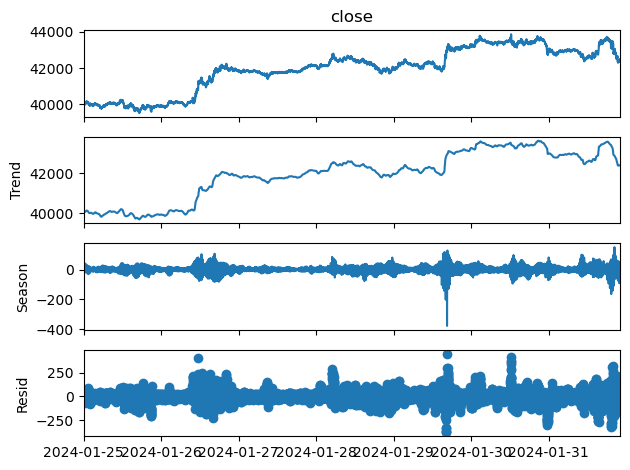

In [19]:
# Extract components
btc_price_data_1_year['trend'] = result.trend
btc_price_data_1_year['seasonal'] = result.seasonal
# btc_price_data_1_year['residual'] = result.resid

# Plot the decomposition
result.plot()
plt.show()

### **TODO**
**Multicollinearity**: Be mindful of multicollinearity, which is when your **features are highly correlated** with each other.  This can make it difficult for your model to learn the individual effects of each feature.  Check the **correlation matrix** of your features.  If you find high correlations (especially **between lagged features**), you might need to **remove some features or use dimensionality reduction techniques like PCA**.

In [20]:
# 1.Rolling Statistics - Rolling mean and standard deviation of each component.
btc_price_data_1_year['trend_rolling_mean'] = btc_price_data_1_year['trend'].rolling(window=24).mean()
btc_price_data_1_year['trend_rolling_std'] = btc_price_data_1_year['trend'].rolling(window=24).std()
# btc_price_data_1_year['residual_rolling_std'] = btc_price_data_1_year['residual'].rolling(window=24).std()

# 2.Differences - Calculate the difference between close price and its trend or seasonality
btc_price_data_1_year['close_trend_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['trend']
btc_price_data_1_year['close_seasonal_diff'] = btc_price_data_1_year['close'] - btc_price_data_1_year['seasonal']

#### 2.3.2. Rolling Statistics

Rolling mean and standard deviation help capture local trends and volatility.

In [21]:
# Rolling windows in hours
windows = [3, 6, 24]

In [22]:
for window in windows:
    # Rolling statistics for 'close' price
    btc_price_data_1_year[f'close_roll_mean_{window}'] = btc_price_data_1_year['close'].rolling(window=window).mean()
    btc_price_data_1_year[f'close_roll_std_{window}'] = btc_price_data_1_year['close'].rolling(window=window).std()
    
    # Volume-based rolling statistics
    btc_price_data_1_year[f'volume_roll_mean_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).mean()
    btc_price_data_1_year[f'volume_roll_std_{window}'] = btc_price_data_1_year['volume'].rolling(window=window).std()

    # Get relationships between price and volume changes.
    btc_price_data_1_year[f'close_volume_interaction_{window}'] = btc_price_data_1_year[f'close_roll_mean_{window}'] * btc_price_data_1_year[f'volume_roll_mean_{window}']


### 2.3. Autocorrelation

Autocorrelation in time series refers to the correlation of a time series with a lagged version of itself. It measures how past values of the series influence current values. Understanding autocorrelation can help identify patterns, trends, and periodicity in time-series data.

##### Why Autocorrelation Matters
- **Pattern Detection**: Helps identify repeating patterns or seasonality.
- **Modeling Assumptions**: Many models (like ARIMA) assume specific autocorrelation structures.
- **Feature Engineering**: Insights from autocorrelation can guide the creation of lag-based features for machine learning models.

##### Types of Autocorrelation
1. **Positive Autocorrelation**: High values follow high values, and low values follow low values.
2. **Negative Autocorrelation**: High values follow low values, and vice versa.
3. **No Autocorrelation**: Values are independent of each other.

##### How to Measure Autocorrelation
The **autocorrelation function (ACF)** and the **partial autocorrelation function (PACF)** are two common tools:

###### 1. **Autocorrelation Function (ACF)**
- Measures the correlation between the time series and its lagged values.
- Useful for identifying the overall pattern of dependence at different lags.

###### 2. **Partial Autocorrelation Function (PACF)**
- Measures the correlation between the time series and its lagged values after removing the influence of shorter lags.
- Useful for determining the direct relationship between a value and a specific lag.


#### 2.3.1. Autocorrelation Function (ACF)

Set the count of the **lags** that will be considered during the Autocorrelation anylysis:

In [23]:
# We use the last day (24 hours) for the autocorrelation analysis
lags = 24

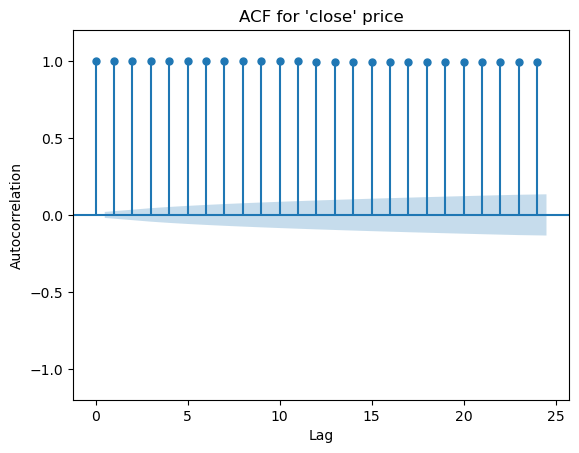

In [24]:
plot_acf(btc_price_data_1_year.close, lags = lags)
plt.ylim(-1.2, 1.2)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF for \'close\' price')
plt.show()

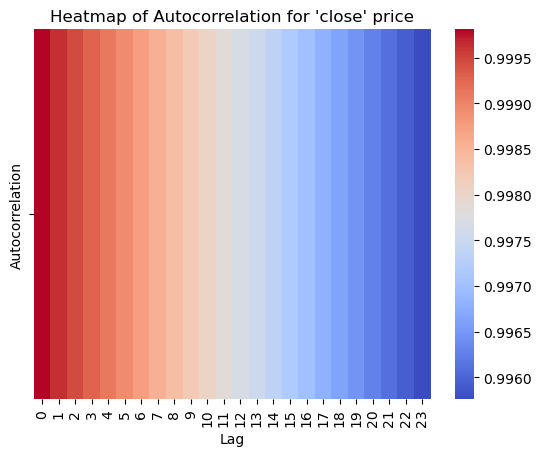

In [25]:
autocorr = [btc_price_data_1_year['close'].autocorr(lag) for lag in range(1, lags+1)]
sns.heatmap(pd.DataFrame(autocorr, columns=["Autocorrelation"]).T, annot=False, cmap="coolwarm")
plt.xlabel('Lag')
plt.title('Heatmap of Autocorrelation for \'close\' price')
plt.show()

Because the **autocorrelation** is very large we use **partial autocorrelation**.

#### 2.3.2. Partial Autocorrelation Function (PACF)

The **Partial Autocorrelation Function (PACF)** measures the partial correlation of a stationary time series with its own lagged values, accounting for the influence of intermediate lags. Unlike the **Autocorrelation Function (ACF)**, which considers all previous lags, the PACF isolates the direct relationship between a variable and its lags.

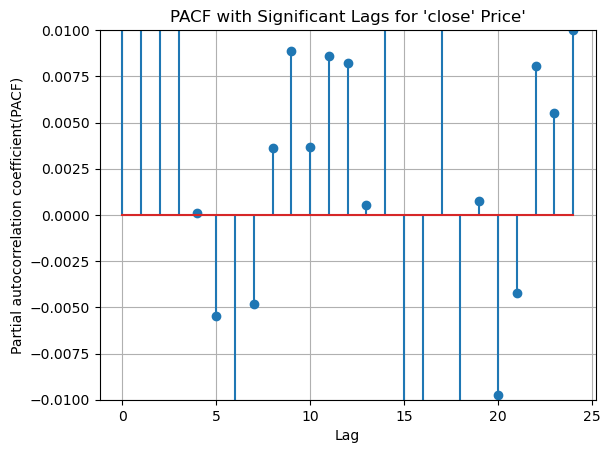

Significant Lags: [ 0  1  3 17 18]


In [26]:
# Calculate PACF
pacf_values = pacf(btc_price_data_1_year['close'], nlags=lags)

# Calculate the confidence interval
conf_int = 1.96 / np.sqrt(len(btc_price_data_1_year['close']))  # The 95% confidence interval

# Get significant lags (values outside the confidence interval)
significant_lags = np.where(np.abs(pacf_values) > conf_int)[0]

# Plot PACF with significant lags marked
plt.stem(pacf_values)

plt.axhline(y=conf_int, color='r', linestyle='--')
plt.axhline(y=-conf_int, color='r', linestyle='--')
plt.ylim(-0.010, 0.010)

plt.grid()

plt.xlabel('Lag')
plt.ylabel('Partial autocorrelation coefficient(PACF)')
plt.title("PACF with Significant Lags for \'close\' Price'")
plt.show()

# Print the significant lags
print("Significant Lags:", significant_lags)

**Significant lags**: Spikes that are outside the area between the two red lines are **statistically significant** at the 95% confidence level.

Correlation coefficients that are between the two red lines are **insignificant** for the model. In this area the **p-value** is too small. Correlations in this area may well be random.

In [27]:
# Remove the autocorrelation with itself (the '0'-th lag)
significant_lags = significant_lags[1:] if significant_lags[0] == 0 else significant_lags
print("Significant Lags:", significant_lags)

Significant Lags: [ 1  3 17 18]


In [28]:
# Create lag features (past values as features)
def create_lag_features(df, lags = []):
    """
    Create lag features (past values as features)
    """
    # Create a copy of the DataFrame
    df_copy = df.copy(deep=True)
    
    for lag in lags:
        df_copy[f'lag_{lag}'] = df_copy['close'].shift(lag)
        
        # Create lagged values of the trend and seasonal
        df_copy[f'trend_lag_{lag}'] = df_copy['trend'].shift(lag)
        df_copy[f'seasonal_lag_{lag}'] = df_copy['seasonal'].shift(lag)

        # Create lagged values of the difference between close price and its trend or seasonality
        df_copy[f'close_trend_diff_lag_{lag}'] = df_copy['close_trend_diff'].shift(lag)
        df_copy[f'close_seasonal_diff_lag_{lag}'] = df_copy['close_seasonal_diff'].shift(lag)
        
    #df.dropna(inplace=True)
    return df_copy

In [29]:
btc_price_data_1_year = create_lag_features(btc_price_data_1_year, significant_lags)

### 2.4. Calculate Target Variable

The **target** variable will be derived from the calculated **future returns**. The values of this variable are used as **buy/sell signals** for the traiding strategy. 

There will be 2 target values:
* 0  - price falls
* 1  - price rises

In [30]:
def create_target(df, forecast_horizon=1):
    df = df.copy()
    
    # Calculate future returns
    df['future_return'] = df['close'].shift(-forecast_horizon) / df['close'] - 1
    
    # Create binary target (1 for price up, 0 for price down)
    df['target'] = (df['future_return'] > 0).astype(int)

    print(df['target'].value_counts())
    
    return df

In [31]:
# Target: Next hour's close price
btc_price_data_1_year = create_target(btc_price_data_1_year, 1)

target
1    5048
0    4952
Name: count, dtype: int64


### 2.5. Clean up the Data

There are some rows in the dataset that have a `NaN` values (`future_return`, `RSI`, `SMA` and some `lag`-columns) due to the feature engineering process. We will delete these rows to clean up the dataset.

In [32]:
btc_price_data_1_year = btc_price_data_1_year.dropna()

In [33]:
btc_price_data_1_year.shape

(9950, 70)

In [34]:
btc_price_data_1_year.isnull().sum()

open                          0
high                          0
low                           0
close                         0
volume                        0
                             ..
seasonal_lag_18               0
close_trend_diff_lag_18       0
close_seasonal_diff_lag_18    0
future_return                 0
target                        0
Length: 70, dtype: int64

In [35]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns',
       'volume_ma', 'volume_std', 'sma_20', 'sma_50', 'ema_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_high', 'bb_low', 'bb_mid', 'hour',
       'day_of_week', 'day_of_month', 'month', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'trend', 'seasonal',
       'trend_rolling_mean', 'trend_rolling_std', 'close_trend_diff',
       'close_seasonal_diff', 'close_roll_mean_3', 'close_roll_std_3',
       'volume_roll_mean_3', 'volume_roll_std_3', 'close_volume_interaction_3',
       'close_roll_mean_6', 'close_roll_std_6', 'volume_roll_mean_6',
       'volume_roll_std_6', 'close_volume_interaction_6', 'close_roll_mean_24',
       'close_roll_std_24', 'volume_roll_mean_24', 'volume_roll_std_24',
       'close_volume_interaction_24', 'lag_1', 'trend_lag_1', 'seasonal_lag_1',
       'close_trend_diff_lag_1', 'close_seasonal_diff_lag_1', 'lag_3',
       'trend_lag_3', 'seasonal_lag_3', 

## 3. Data Preprocessing

### 3.1. One-hot encoding for categorical features

In [36]:
btc_price_data_1_year = pd.get_dummies(btc_price_data_1_year, columns=['day_of_week', 'day_of_month', 'month'], drop_first=True) # drop_first to avoid multicollinearity

In [37]:
btc_price_data_1_year.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'log_returns',
       'volume_ma', 'volume_std', 'sma_20', 'sma_50', 'ema_20', 'rsi', 'macd',
       'macd_signal', 'macd_diff', 'bb_high', 'bb_low', 'bb_mid', 'hour',
       'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'trend',
       'seasonal', 'trend_rolling_mean', 'trend_rolling_std',
       'close_trend_diff', 'close_seasonal_diff', 'close_roll_mean_3',
       'close_roll_std_3', 'volume_roll_mean_3', 'volume_roll_std_3',
       'close_volume_interaction_3', 'close_roll_mean_6', 'close_roll_std_6',
       'volume_roll_mean_6', 'volume_roll_std_6', 'close_volume_interaction_6',
       'close_roll_mean_24', 'close_roll_std_24', 'volume_roll_mean_24',
       'volume_roll_std_24', 'close_volume_interaction_24', 'lag_1',
       'trend_lag_1', 'seasonal_lag_1', 'close_trend_diff_lag_1',
       'close_seasonal_diff_lag_1', 'lag_3', 'trend_lag_3', 'seasonal_lag_3',
       'close_trend_diff_lag_3', 'close_seasona

### 3.2. Split the Dataset

Typically, for time series, the data is split chronologically to avoid data leakage. For example:
- **Training set**: 80% of the data (used for training the model).
- **Validation set**: 10% of the data (used for hyperparameter tuning).
- **Test set**: 10% of the data (used to evaluate final performance).

In [38]:
# Sort the dataset by time to maintain chronological order
# btc_price_data_1_year = btc_price_data_1_year.sort_values(by='timestamp')  # Replace 'timestamp' with your time column if named differently

# # Split the dataset into train, validation, and test sets
# train_size = 0.8
# val_size = 0.1
# test_size = 0.1

# # Compute split indices
# train_idx = int(len(btc_price_data_1_year) * train_size)
# val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# # Split the data
# btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
# btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
# btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]

# Split data
X = btc_price_data_1_year.drop('target', axis=1)
y = btc_price_data_1_year['target']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# print(f"Training set: {len(btc_price_data_1_year_train)} rows")
# print(f"Validation set: {len(btc_price_data_1_year_val)} rows")
# print(f"Test set: {len(btc_price_data_1_year_test)} rows")

print(f"Training set: {len(X_train)} rows")
print(f"Validation set: {len(X_val)} rows")
print(f"Test set: {len(X_test)} rows")

Training set: 7960 rows
Validation set: 995 rows
Test set: 995 rows


In [39]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

In [40]:
# dates_train = btc_price_data_1_year_train.index
# prices_close_train = btc_price_data_1_year_train.close

# dates_val = btc_price_data_1_year_val.index
# prices_close_val = btc_price_data_1_year_val.close

# dates_test = btc_price_data_1_year_test.index
# prices_close_test = btc_price_data_1_year_test.close

# dates = [dates_train, dates_val, dates_test]
# prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

# title_btc = 'Data Split (Jan 2024 - Jan 2025)'

# labels = ['Date', 'Price [USD]']

# plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

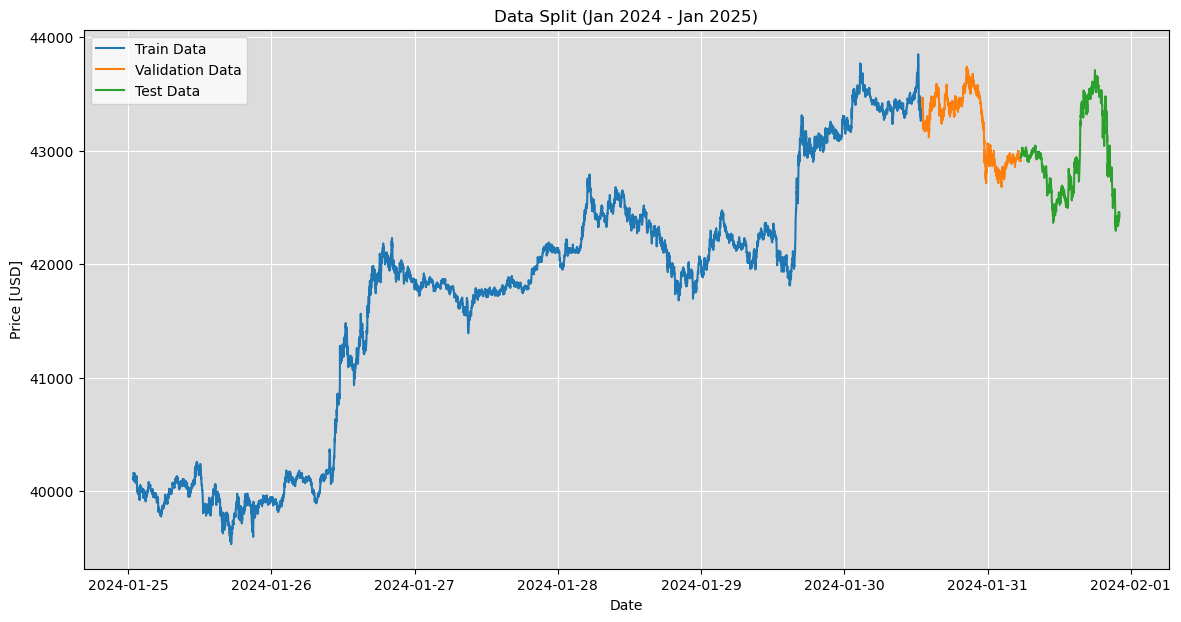

In [41]:
dates_train = X_train.index
prices_close_train = X_train.close

dates_val = X_val.index
prices_close_val = X_val.close

dates_test = X_test.index
prices_close_test = X_test.close

dates = [dates_train, dates_val, dates_test]
prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

title_btc = 'Data Split (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 3.3. Scale Features

1. Define the features to scale (numerical columns).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [42]:
# Exclude already normalized features like 'hour_sin'/'hour_cos'
# features_to_exclude = ['hour_sin', 'hour_cos','day_of_week_sin', 'day_of_week_cos']
# features_to_exclude = [['hour_sin', 'hour_cos','day_sin', 'day_cos']]
# Exclude already normalized features like 'hour_sin'/'hour_cos' and the 'target'('target' is categorical variable)
# features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'target']

features_to_exclude = []
for x in btc_price_data_1_year.columns:
    if x.startswith('day_of_week') or x.startswith('day_of_month') or x.startswith('month') or x.startswith('hour') or x.startswith('target'):
        features_to_exclude.append(x)

# Select the remaining columns
numericel_features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale selected features
# scaler = StandardScaler()
X_train_scaled = X_train.copy() # important
X_val_scaled = X_val.copy() # important
X_test_scaled = X_test.copy() # important

# Fit the scaler ONLY on the training set and transform all sets
X_train_scaled[numericel_features_to_scale] = scaler.fit_transform(X_train[numericel_features_to_scale])
X_val_scaled[numericel_features_to_scale] = scaler.transform(X_val[numericel_features_to_scale])
X_test_scaled[numericel_features_to_scale] = scaler.transform(X_test[numericel_features_to_scale])

# # Convert back to DataFrames (optional but recommended for easier handling)
# X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
# X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


# # Fit the scaler ONLY on the training set and transform all sets
# btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
# btc_price_data_1_year_val.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_val[features_to_scale])
# btc_price_data_1_year_test.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_test[features_to_scale])

### 3.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, you typically convert the flat features into sequences.

In [43]:
def create_sequences(X, y, timesteps):
    # Convert inputs to numpy arrays if they're not already
    if hasattr(X, 'values'):
        X_array = X.values
    else:
        X_array = np.array(X)
    if hasattr(y, 'values'):
        y_array = y.values
    else:
        y_array = np.array(y)
    
    # Ensure X_array has shape (samples, num_features)
    # If not, adjust (for example, if it is transposed)
    if X_array.shape[0] < X_array.shape[1]:
        X_array = X_array.T

    # Create the sliding window view along the time axis (axis=0)
    X_seq = np.lib.stride_tricks.sliding_window_view(X_array, window_shape=timesteps, axis=0)
    # X_seq is expected to have shape (samples - timesteps + 1, timesteps, num_features)
    
    # Sometimes the window axis might appear in a different position,
    # so check if the last dimension matches the number of features.
    if X_seq.shape[-1] != X_array.shape[1]:
        # If not, swap the last two axes
        X_seq = np.swapaxes(X_seq, -1, -2)

    # Since the original loop created windows for indices timesteps to len(X)-1,
    # we take all but the last sliding window to match the target length.
    X_seq = X_seq[:-1]
    
    # The corresponding target values from y start at index `timesteps`
    y_seq = y_array[timesteps:]

    # Ensure both arrays have a numeric dtype (e.g., float32)
    X_seq = X_seq.astype(np.float32)
    y_seq = y_seq.astype(np.float32)
    
    return X_seq, y_seq

In [44]:
# Define the number of timesteps (sequence length) for LSTM
TIMESTEPS = 24  # Example: Look at the past 24 hours
X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIMESTEPS)
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")

X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, TIMESTEPS)
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")

X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, TIMESTEPS)
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

X_train_seq shape: (7936, 24, 78), y_train_seq shape: (7936,)
X_val_seq shape: (971, 24, 78), y_val_seq shape: (971,)
X_test_seq shape: (971, 24, 78), y_test_seq shape: (971,)


In [45]:
print(X_train_scaled.columns.values)

['open' 'high' 'low' 'close' 'volume' 'returns' 'log_returns' 'volume_ma'
 'volume_std' 'sma_20' 'sma_50' 'ema_20' 'rsi' 'macd' 'macd_signal'
 'macd_diff' 'bb_high' 'bb_low' 'bb_mid' 'hour' 'hour_sin' 'hour_cos'
 'day_of_week_sin' 'day_of_week_cos' 'trend' 'seasonal'
 'trend_rolling_mean' 'trend_rolling_std' 'close_trend_diff'
 'close_seasonal_diff' 'close_roll_mean_3' 'close_roll_std_3'
 'volume_roll_mean_3' 'volume_roll_std_3' 'close_volume_interaction_3'
 'close_roll_mean_6' 'close_roll_std_6' 'volume_roll_mean_6'
 'volume_roll_std_6' 'close_volume_interaction_6' 'close_roll_mean_24'
 'close_roll_std_24' 'volume_roll_mean_24' 'volume_roll_std_24'
 'close_volume_interaction_24' 'lag_1' 'trend_lag_1' 'seasonal_lag_1'
 'close_trend_diff_lag_1' 'close_seasonal_diff_lag_1' 'lag_3'
 'trend_lag_3' 'seasonal_lag_3' 'close_trend_diff_lag_3'
 'close_seasonal_diff_lag_3' 'lag_17' 'trend_lag_17' 'seasonal_lag_17'
 'close_trend_diff_lag_17' 'close_seasonal_diff_lag_17' 'lag_18'
 'trend_lag_18' '

In [46]:
X_train_scaled.describe()[['hour','hour_sin', 'hour_cos','day_of_week_sin', 'day_of_week_cos']].T

,count,mean,std,min,25%,50%,75%,max
hour,7960.0,11.031407,6.841116,0.000000,5.000000,1.100000e+01,17.000000,23.000000
hour_sin,7960.0,0.057341,0.704232,-1.000000,-0.707107,1.224647e-16,0.707107,1.000000
hour_cos,7960.0,-0.006596,0.707708,-1.000000,-0.707107,6.123234e-17,0.707107,1.000000
day_of_week_sin,7960.0,-0.244434,0.592730,-0.974928,-0.781831,-4.338837e-01,0.433884,0.781831
day_of_week_cos,7960.0,-0.005690,0.767469,-0.900969,-0.900969,-2.225209e-01,0.623490,1.000000


## 4. Define Model Architecture

### 4.1. Model Definition

Create an advanced CNN-LSTM model architecture specifically designed for our data.

The model architecture includes:
   - Multiple CNN layers to capture patterns in technical indicators
   - Batch normalization to stabilize training
   - LSTM layers to capture temporal dependencies
   - Dropout for regularization
   - Dense layers for final prediction

In [47]:
def create_cnn_lstm_model(input_shape, dropout_rate=0.3):
    """
    Creates a CNN-LSTM hybrid model optimized for cryptocurrency price prediction.
    
    Parameters:
    input_shape: Tuple of (sequence_length, n_features)
    dropout_rate: Dropout rate for regularization
    """
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # First CNN block - captures local patterns in technical indicators
    x = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Second CNN block - captures more complex patterns
    x = tf.keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # LSTM layers - capture temporal dependencies
    x = tf.keras.layers.LSTM(
        units=128,
        return_sequences=True
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    x = tf.keras.layers.LSTM(
        units=64,
        return_sequences=False
    )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Dense layers for final prediction
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Output layer - binary classification
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Create and compile model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

### 4.2. Train the model

The training process includes:
   - Early stopping to prevent overfitting
   - Learning rate reduction when progress stalls
   - Model checkpointing to save the best version
   - Multiple metrics to track performance

In [48]:
def train_model(X_train, y_train, X_val, y_val, input_shape, epochs=100, batch_size=32):
    """
    Trains the CNN-LSTM model with proper callbacks and monitoring.
    """
    # Create model
    model = create_cnn_lstm_model(input_shape)

    model.summary()
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    filepath = 'models/best_model_{epoch:02d}-{loss:.4f}-{val_loss:.4f}.h5.keras'
    
    # Define callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        # Reduce learning rate when progress stalls
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001
        ),
       
        # Model checkpoint to save best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath,
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

The data pipeline ensures:
   - Proper temporal ordering is maintained
   - No data leakage between sets
   - Appropriate scaling of features

In [49]:
# Get input shape from training data
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

# Train model
model, history = train_model(X_train_seq, y_train_seq, X_val_seq, y_val_seq, input_shape, epochs = 100)



# Evaluate on test set
test_results = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print("\nTest results:")
for metric, value in zip(model.metrics_names, test_results):
    print(f"{metric}: {value:.4f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 78)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 24, 64)              │          15,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 6, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,617 (873.50 KB)

 Trainable params: 223,233 (872.00 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.4991 - auc: 0.4925 - loss: 0.6996 - precision: 0.5135 - recall: 0.4844 - val_accuracy: 0.4954 - val_auc: 0.4944 - val_loss: 0.6933 - val_precision: 0.4954 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5083 - auc: 0.4950 - loss: 0.6950 - precision: 0.5152 - recall: 0.7362 - val_accuracy: 0.5046 - val_auc: 0.5048 - val_loss: 0.6940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5001 - auc: 0.4965 - loss: 0.6939 - precision: 0.5082 - recall: 0.7172 - val_accuracy: 0.4954 - val_auc: 0.4914 - val_loss: 0.6934 - val_precision: 0.4954 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5093 - auc: 0.5050 - loss: 0.6930 - precision: 0.5155 - recall: 0.7826 - val_accuracy: 0.4954 - val_auc: 0.5000 - val_l

In [50]:
# def run_complete_pipeline(df):
#     # Split and scale data
#     (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = split_and_scale_data(df)
    
#     # Get input shape from training data
#     input_shape = (X_train.shape[1], X_train.shape[2])
    
#     # Train model
#     model, history = train_model(X_train, y_train, X_val, y_val, input_shape, epochs = 5)
    
#     # Evaluate on test set
#     test_results = model.evaluate(X_test, y_test, verbose=0)
#     print("\nTest results:")
#     for metric, value in zip(model.metrics_names, test_results):
#         print(f"{metric}: {value:.4f}")
    
#     return model, history, scaler

In [51]:
# # Run the pipeline
# model, history, scaler = run_complete_pipeline(btc_price_data_1_year)

### 4.3. Evaluate the Model

These visualization and analysis tools will help you understand:
1. How well your model learned during training
2. Where your model performs well and where it struggles
3. If there are patterns in the prediction errors
4. How the model's performance varies across different time periods
5. The reliability of the model's probability estimates

#### Visualize the training history and model performance

In [52]:
def plot_training_history(history):
    """
    Visualizes the model's training history, showing how metrics evolved over epochs.
    """
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training & validation loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training & validation accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

#### Analyze the model's predictions 

In [53]:
def analyze_predictions(model, X_test, y_test, threshold=0.5):
    """
    Comprehensive analysis of model predictions including confusion matrix,
    ROC curve, and detailed metrics.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    ax2.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    
    # 3. Prediction Distribution
    sns.histplot(y_pred_proba, bins=50, ax=ax3)
    ax3.axvline(threshold, color='r', linestyle='--', 
                label=f'Threshold ({threshold})')
    ax3.set_title('Distribution of Prediction Probabilities')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # 4. Classification Report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    ax4.axis('off')
    ax4.table(cellText=report_df.round(3).values,
              rowLabels=report_df.index,
              colLabels=report_df.columns,
              cellLoc='center',
              loc='center')
    ax4.set_title('Classification Report')
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba, y_pred

#### Analyze prediction errors and identify patterns

In [54]:
def analyze_prediction_errors(model, X_test, y_test, processed_df, scaler, threshold=0.5):
    """
    Analyzes when and why the model makes incorrect predictions.
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Create error analysis DataFrame
    error_analysis = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Probability': y_pred_proba.flatten(),
        'Error': y_test != y_pred.flatten()
    })
    
    # # Add relevant features from processed_df
    # # Note: You'll need to align the indices properly based on your data structure
    # error_analysis['Hour'] = processed_df['hour'].iloc[-len(y_test):]
    # error_analysis['Day_of_Week'] = processed_df['day_of_week'].iloc[-len(y_test):]
    
    # Create visualizations for error analysis
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # # 1. Error rate by hour of day
    # error_by_hour = error_analysis[error_analysis['Error']].groupby('Hour').size() / \
    #                 error_analysis.groupby('Hour').size()

    # print(f'error_by_hour: {error_by_hour}')

    # if len(error_by_hour) > 0:
    #     error_by_hour.plot(kind='bar', ax=ax1)
    #     ax1.set_title('Error Rate by Hour of Day')
    #     ax1.set_xlabel('Hour')
    #     ax1.set_ylabel('Error Rate')
    
    # # 2. Error rate by day of week
    # error_by_day = error_analysis[error_analysis['Error']].groupby('Day_of_Week').size() / \
    #                error_analysis.groupby('Day_of_Week').size()
    # if len(error_by_day) > 0:
    #     error_by_day.plot(kind='bar', ax=ax2)
    #     ax2.set_title('Error Rate by Day of Week')
    #     ax2.set_xlabel('Day of Week')
    #     ax2.set_ylabel('Error Rate')
    
    # 3. Probability distribution for correct vs incorrect predictions
    sns.kdeplot(data=error_analysis, x='Probability', hue='Error', ax=ax3)
    ax3.set_title('Prediction Probability Distribution\nCorrect vs Incorrect Predictions')
    
    # 4. Confusion matrix with percentages
    cm_percent = confusion_matrix(y_test, y_pred, normalize='true')
    sns.heatmap(cm_percent, annot=True, fmt='.2%', ax=ax4)
    ax4.set_title('Confusion Matrix (Percentages)')
    
    plt.tight_layout()
    plt.show()
    
    return error_analysis

#### Evaluate the model's performance over different time horizons

In [55]:
def evaluate_prediction_horizons(model, X_test, y_test, processed_df):
    """
    Evaluates how the model's performance varies over different prediction horizons.
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Create DataFrames for analysis
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred.flatten(),
        'Timestamp': processed_df.index[-len(y_test):]
    })
    
    # Calculate rolling accuracy
    window_sizes = [24, 72, 168]  # 1 day, 3 days, 1 week
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot rolling accuracy for different windows
    for window in window_sizes:
        rolling_acc = (
            (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
            .rolling(window)
            .mean()
        )
        rolling_acc.plot(ax=ax1, label=f'{window}h Rolling Accuracy')
    
    ax1.set_title('Rolling Accuracy Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot cumulative accuracy
    cumulative_acc = (
        (predictions_df['Actual'] == (predictions_df['Predicted'] > 0.5))
        .cumsum() / range(1, len(predictions_df) + 1)
    )
    cumulative_acc.plot(ax=ax2)
    ax2.set_title('Cumulative Accuracy Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Cumulative Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return predictions_df

#### Start Complete Analysis

In [56]:
def perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler):
    """
    Performs a complete analysis of the model's performance.
    """
    print("1. Analyzing training history...")
    plot_training_history(history)
    
    print("\n2. Analyzing predictions...")
    y_pred_proba, y_pred = analyze_predictions(model, X_test, y_test)
    
    print("\n3. Analyzing prediction errors...")
    error_analysis = analyze_prediction_errors(model, X_test, y_test, processed_df, scaler)
    
    print("\n4. Evaluating prediction horizons...")
    predictions_df = evaluate_prediction_horizons(model, X_test, y_test, processed_df)
    
    return {
        'predictions': predictions_df,
        'error_analysis': error_analysis,
        'probabilities': y_pred_proba,
        'predicted_classes': y_pred
    }

1. Analyzing training history...


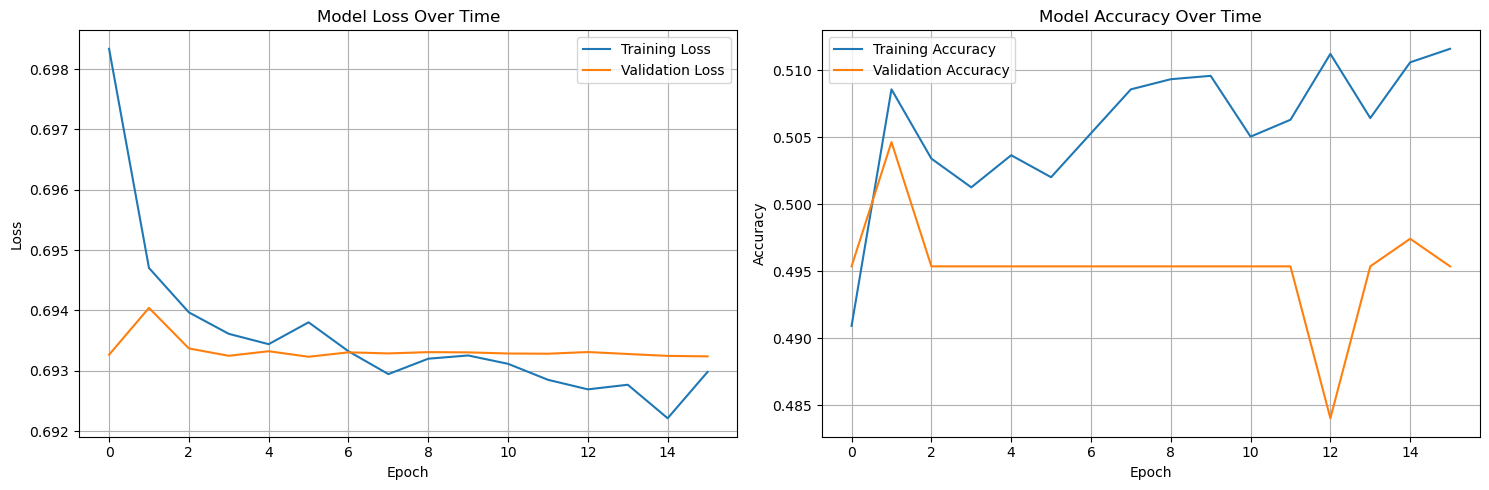


2. Analyzing predictions...
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


C:\Users\valch\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\valch\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\valch\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

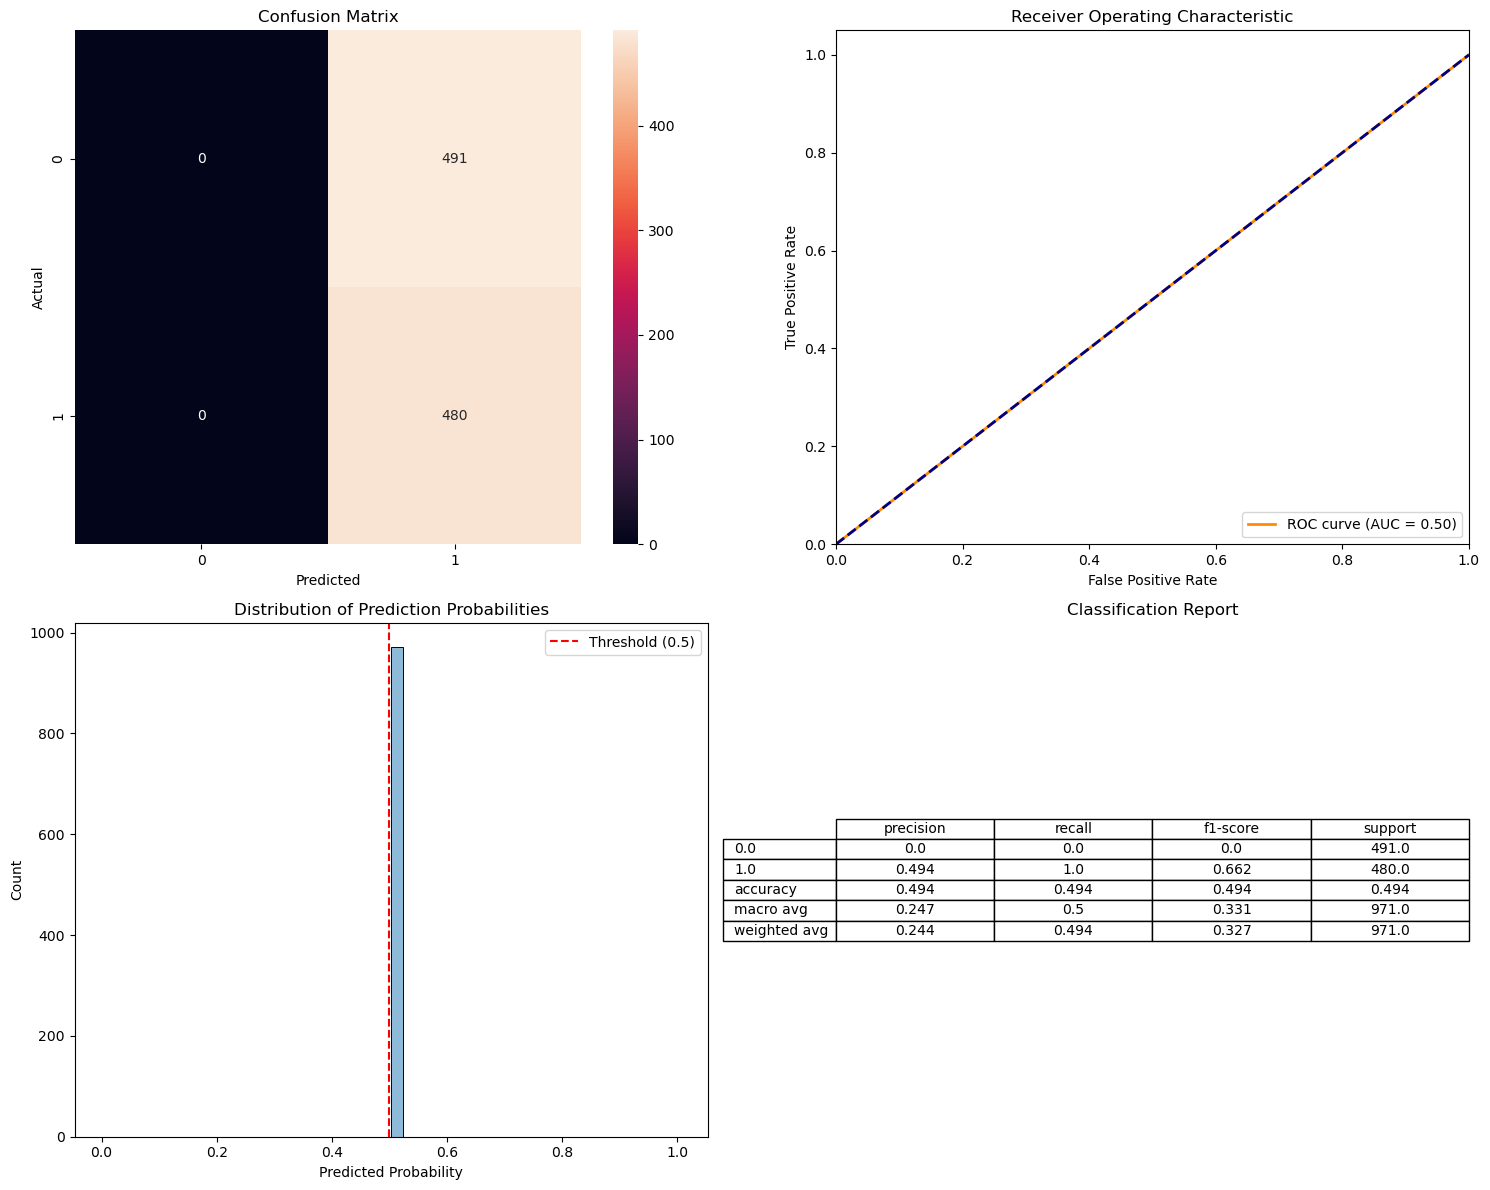


3. Analyzing prediction errors...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


C:\Users\valch\AppData\Local\Temp\ipykernel_10716\2697938916.py:47: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=error_analysis, x='Probability', hue='Error', ax=ax3)


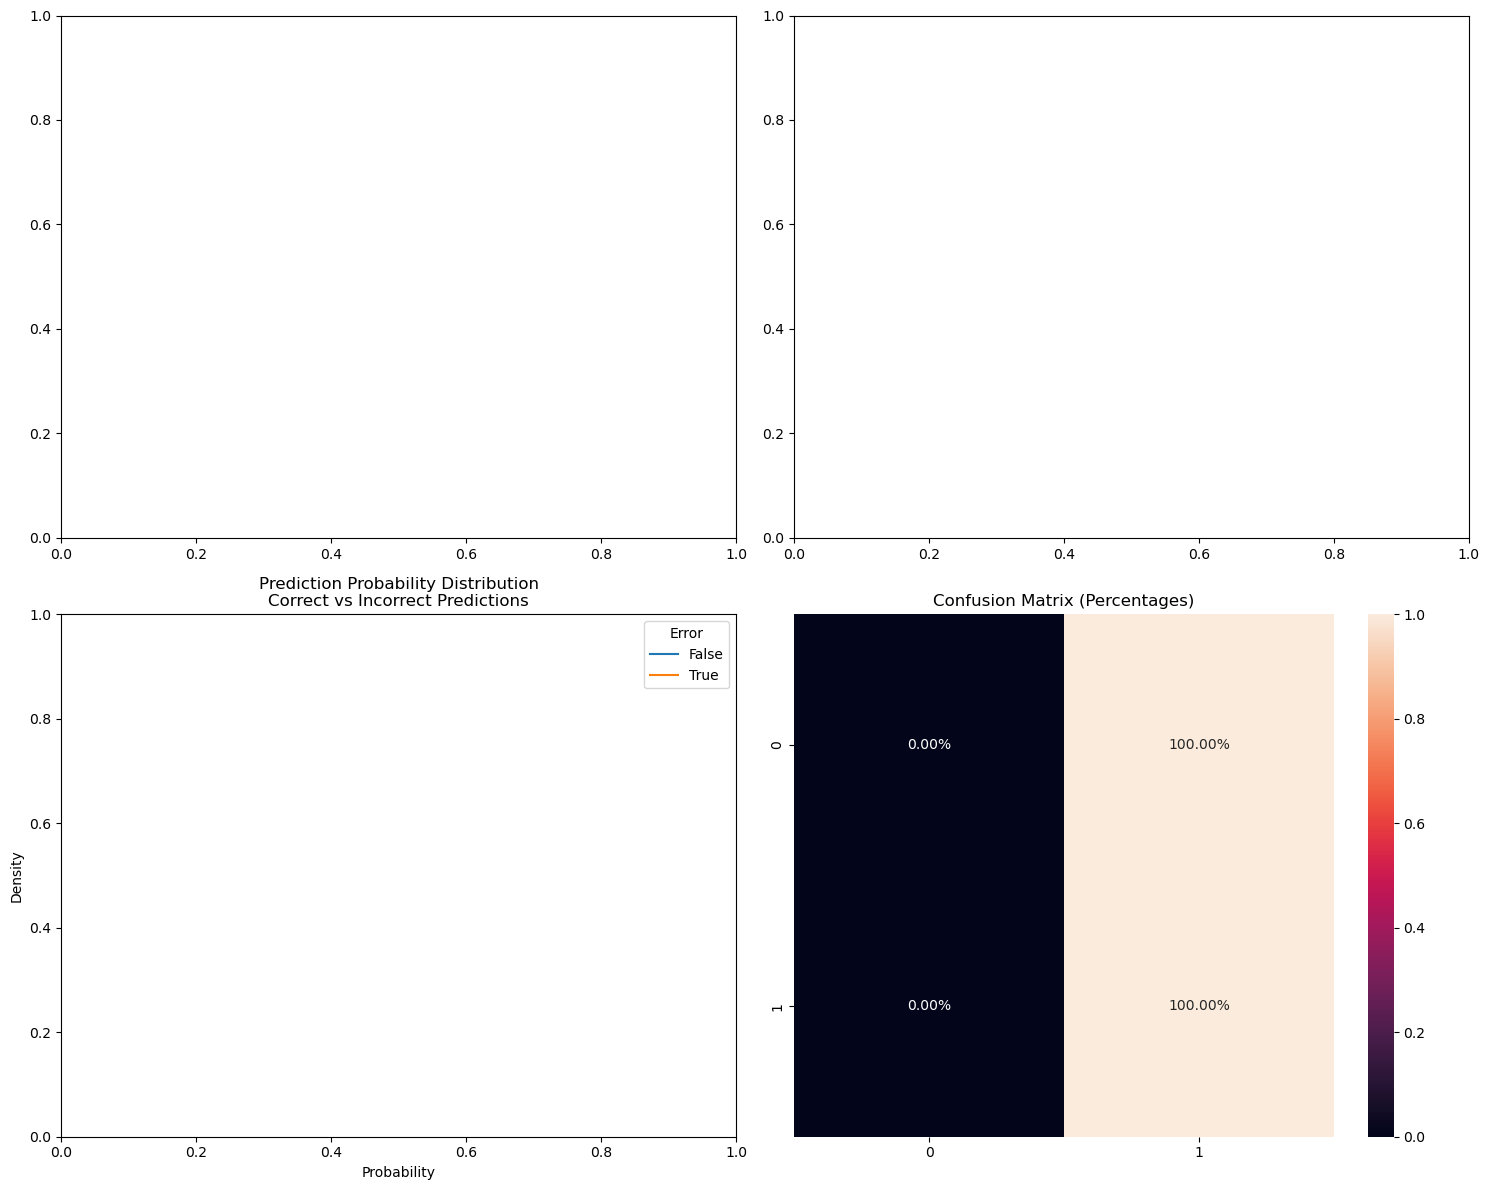


4. Evaluating prediction horizons...
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


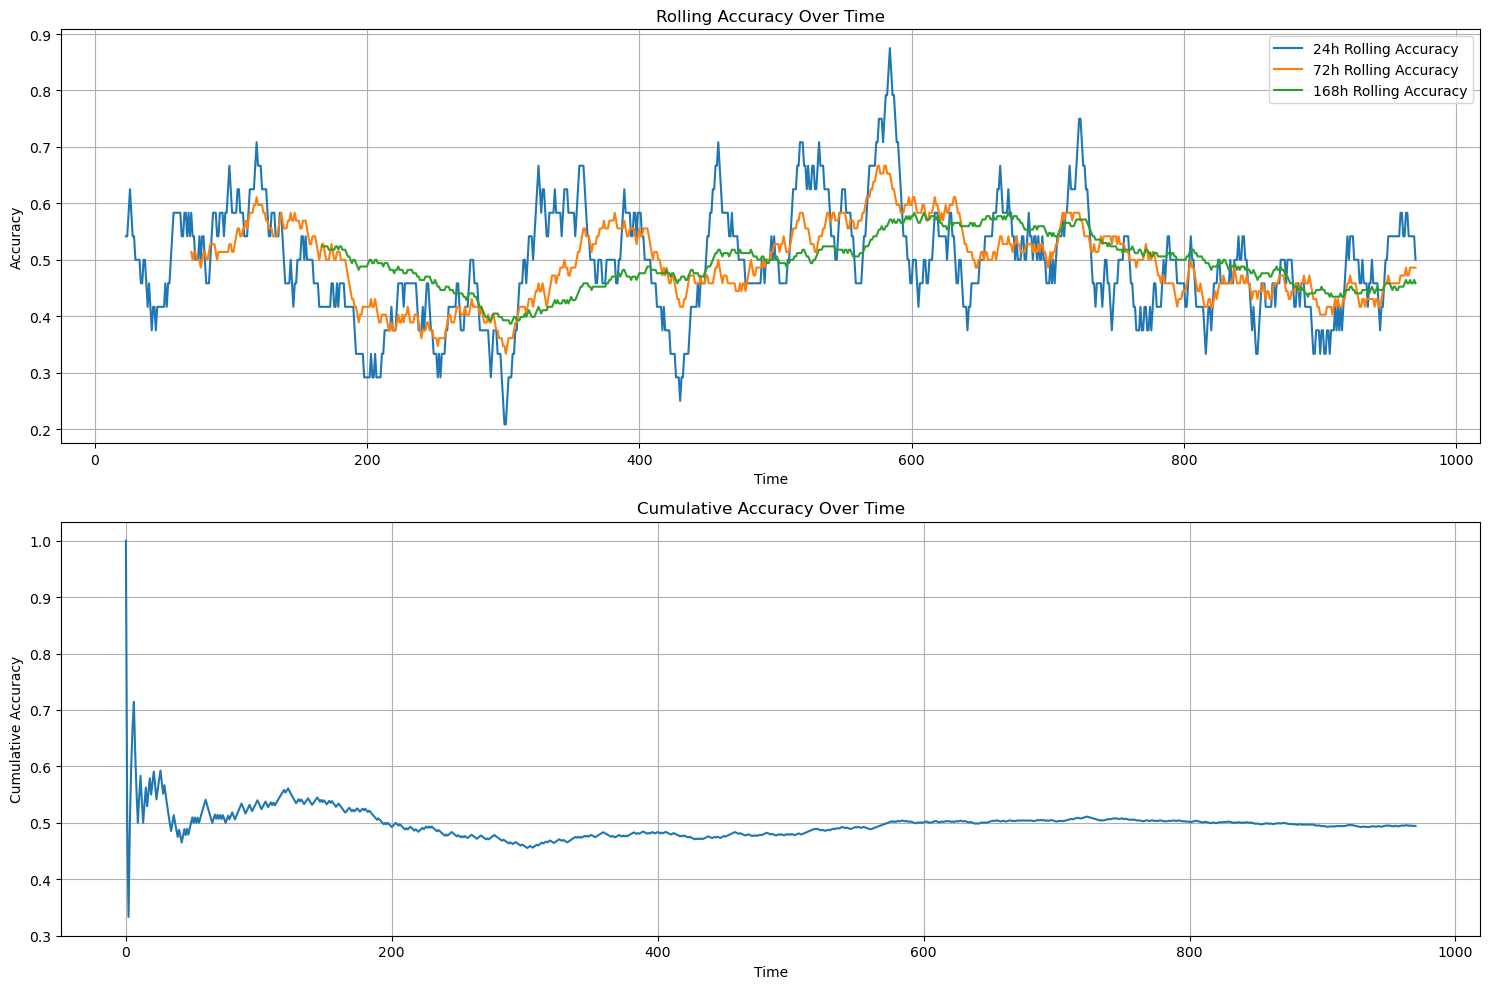

In [57]:
# Analysis results
analysis_results = perform_complete_analysis(model, X_test_seq, y_test_seq, btc_price_data_1_year, history, scaler)

In [58]:
# def run_complete_pipeline(df):
#     # Split and scale data
#     (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, processed_df = split_and_scale_data(df)
    
#     # Get input shape from training data
#     input_shape = (X_train.shape[1], X_train.shape[2])
    
#     # Train model
#     model, history = train_model(X_train, y_train, X_val, y_val, input_shape, epochs = 1)
    
#     # Evaluate on test set
#     test_results = model.evaluate(X_test, y_test, verbose=0)
#     print("\nTest results:")
#     for metric, value in zip(model.metrics_names, test_results):
#         print(f"{metric}: {value:.4f}")

#     # Analysis results
#     analysis_results = perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler)
    
#     return model, history, scaler

<!-- I'll help you create comprehensive visualization and analysis tools to understand your model's performance. Let's break this down into different aspects of model analysis and create visualization functions for each.

First, let's create functions to visualize the training history and model performance:

```python
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np -->



In [59]:
# # Run the pipeline
# model, history, scaler = run_complete_pipeline(btc_price_data_1_year)

### 4.4. Interpreting Visualizations and Metrics

To use these analysis tools effectively:

1. Start with the training history to identify basic fitting issues
2. Use the ROC curve and confusion matrix to understand classification performance
3. Analyze prediction distributions to understand model confidence
4. Look for temporal patterns in errors
5. Use the comprehensive analysis to get specific improvement recommendations

#### 1. Training History Plots

The training history plots show loss and accuracy curves for both training and validation sets.

When examining the curves, look for these patterns:
- If both training and validation loss are high and flat: The model is underfitting
- If training loss keeps decreasing but validation loss increases: The model is overfitting
- If both curves converge smoothly: The model has found a good balance

In [60]:
def interpret_training_curves(history):
    """
    Visualizes and analyzes training curves to identify learning patterns
    """
    plot_training_history(history)
    
    # Calculate key metrics for interpretation
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    loss_gap = final_val_loss - final_train_loss
    
    print("Training Pattern Analysis:")
    
    if final_train_loss > 0.3:  # This threshold can be adjusted
        print("High training loss suggests underfitting. Consider:")
        print("- Increasing model capacity (add more layers/neurons)")
        print("- Training for more epochs")
        print("- Reducing regularization (lower dropout rate)")
    
    if loss_gap > 0.1:  # This threshold can be adjusted
        print("\nLarge gap between training and validation loss suggests overfitting. Consider:")
        print("- Adding dropout layers")
        print("- Reducing model complexity")
        print("- Using early stopping")
        print("- Collecting more training data")

#### 2. Confusion Matrix and ROC Curve Analysis

In [61]:
def analyze_classification_metrics(model, X_test, y_test):
    """
    Analyzes classification metrics to identify model strengths and weaknesses
    """
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print("Model Performance Analysis:")
    
    # Analyze true positive rate and false positive rate
    tpr = cm[1,1] / (cm[1,1] + cm[1,0])  # Sensitivity
    tnr = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity
    
    print(f"\nAUC Score: {roc_auc:.3f}")
    if roc_auc < 0.7:
        print("Low AUC suggests poor discriminative ability. Consider:")
        print("- Adding more relevant features")
        print("- Feature engineering")
        print("- Trying different model architectures")
    
    print(f"\nSensitivity (True Positive Rate): {tpr:.3f}")
    print(f"Specificity (True Negative Rate): {tnr:.3f}")
    
    # Analyze balance of predictions
    if abs(tpr - tnr) > 0.2:
        print("\nImbalanced prediction performance detected. Consider:")
        print("- Class weighting in model")
        print("- Adjusting decision threshold")
        print("- Addressing data imbalance")

#### 3. Prediction Distribution Analysis

In [62]:
def analyze_prediction_distribution(y_pred_proba, y_test):
    """
    Analyzes the distribution of prediction probabilities
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50)
    plt.axvline(0.5, color='r', linestyle='--', label='Default Threshold')
    plt.title('Distribution of Prediction Probabilities')
    plt.show()
    
    # Analyze prediction confidence
    low_confidence = np.mean((y_pred_proba > 0.4) & (y_pred_proba < 0.6))
    
    print("Prediction Confidence Analysis:")
    print(f"Proportion of low confidence predictions: {low_confidence:.3f}")
    
    if low_confidence > 0.3:
        print("\nHigh proportion of low confidence predictions. Consider:")
        print("- Adding more discriminative features")
        print("- Increasing model capacity")
        print("- Using ensemble methods")

#### 4. Error Analysis Over Time

In [63]:
def analyze_temporal_patterns(error_analysis):
    """
    Analyzes patterns in prediction errors over different time periods
    """
    # Analyze error rates by time period
    hourly_error_rate = error_analysis.groupby('Hour')['Error'].mean()
    # daily_error_rate = error_analysis.groupby('Day_of_Week')['Error'].mean()
    
    print("Temporal Pattern Analysis:")
    
    # Find hours with high error rates
    problem_hours = hourly_error_rate[hourly_error_rate > hourly_error_rate.mean() + hourly_error_rate.std()]
    if not problem_hours.empty:
        print("\nHigh error rates detected during hours:", problem_hours.index.tolist())
        print("Consider:")
        print("- Adding more features specific to these time periods")
        print("- Creating separate models for different time periods")
        print("- Adding more training data for these periods")
    
    # # Analyze weekly patterns
    # if daily_error_rate.std() > 0.1:
    #     print("\nSignificant variation in daily error rates detected. Consider:")
    #     print("- Adding more day-specific features")
    #     print("- Creating separate models for different days")

#### 5. Putting It All Together

In [64]:
def comprehensive_model_analysis(model, X_test, y_test, history, processed_df):
    """
    Performs comprehensive analysis and provides specific improvement recommendations
    """
    print("=== Comprehensive Model Analysis ===\n")
    
    # Analyze training patterns
    interpret_training_curves(history)
    
    print("\n=== Classification Performance ===")
    analyze_classification_metrics(model, X_test, y_test)
    
    # Get predictions for further analysis
    y_pred_proba = model.predict(X_test)
    print("\n=== Prediction Confidence Analysis ===")
    analyze_prediction_distribution(y_pred_proba, y_test)
    
    # Create error analysis DataFrame
    error_analysis = pd.DataFrame({
        'Hour': processed_df['hour'].iloc[-len(y_test):],
        # 'Day_of_Week': processed_df['day_of_week'].iloc[-len(y_test):],
        'Error': y_test != (y_pred_proba >= 0.5).astype(int).flatten()
    })
    
    print("\n=== Temporal Pattern Analysis ===")
    analyze_temporal_patterns(error_analysis)
    
    # Final recommendations
    print("\n=== Overall Recommendations ===")
    compile_final_recommendations(history, y_pred_proba, error_analysis)

def compile_final_recommendations(history, y_pred_proba, error_analysis):
    """
    Compiles final recommendations based on all analyses
    """
    recommendations = []
    
    # Check for underfitting/overfitting
    if history.history['val_loss'][-1] > history.history['loss'][-1] * 1.1:
        recommendations.append("Model shows signs of overfitting:")
        recommendations.append("- Increase dropout rate")
        recommendations.append("- Add L1/L2 regularization")
        recommendations.append("- Reduce model complexity")
    
    # Check prediction confidence
    low_confidence = np.mean((y_pred_proba > 0.4) & (y_pred_proba < 0.6))
    if low_confidence > 0.3:
        recommendations.append("\nLow prediction confidence detected:")
        recommendations.append("- Consider ensemble methods")
        recommendations.append("- Add more feature engineering")
    
    # Check temporal patterns
    if error_analysis.groupby('Hour')['Error'].std().any() > 0.1:
        recommendations.append("\nSignificant temporal patterns detected:")
        recommendations.append("- Consider time-based feature engineering")
        recommendations.append("- Implement separate models for different time periods")
    
    print("\n".join(recommendations))

=== Comprehensive Model Analysis ===



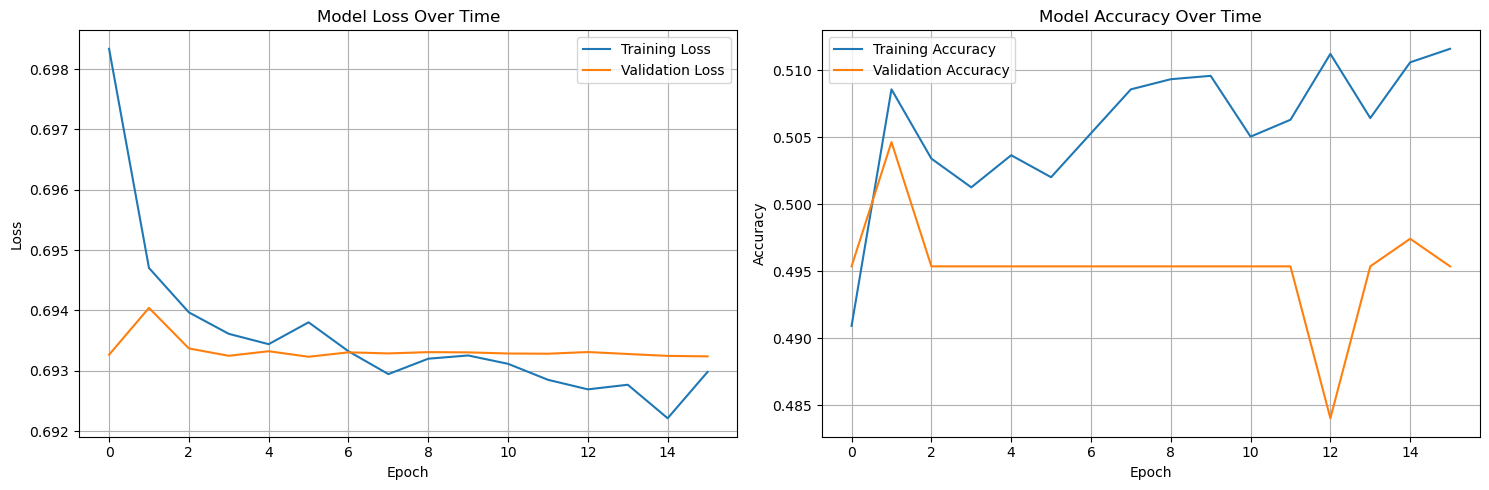

Training Pattern Analysis:
High training loss suggests underfitting. Consider:
- Increasing model capacity (add more layers/neurons)
- Training for more epochs
- Reducing regularization (lower dropout rate)

=== Classification Performance ===
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model Performance Analysis:

AUC Score: 0.500
Low AUC suggests poor discriminative ability. Consider:
- Adding more relevant features
- Feature engineering
- Trying different model architectures

Sensitivity (True Positive Rate): 1.000
Specificity (True Negative Rate): 0.000

Imbalanced prediction performance detected. Consider:
- Class weighting in model
- Adjusting decision threshold
- Addressing data imbalance
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

=== Prediction Confidence Analysis ===


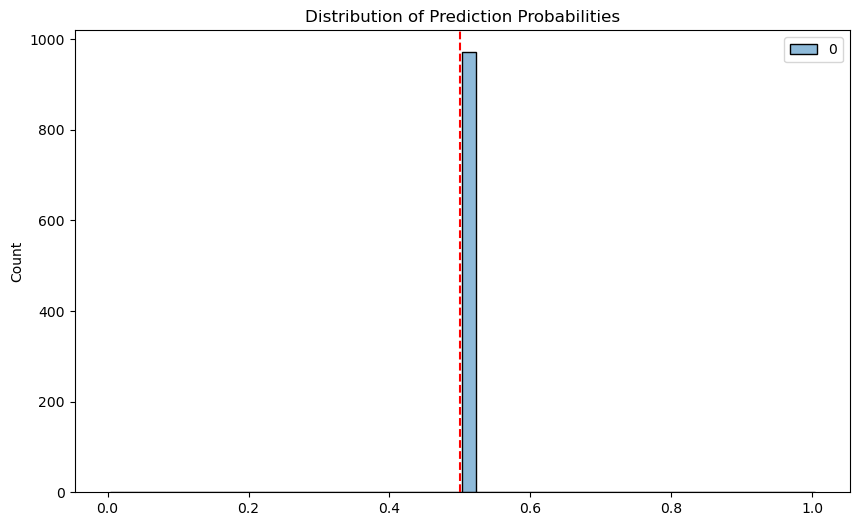

Prediction Confidence Analysis:
Proportion of low confidence predictions: 1.000

High proportion of low confidence predictions. Consider:
- Adding more discriminative features
- Increasing model capacity
- Using ensemble methods

=== Temporal Pattern Analysis ===
Temporal Pattern Analysis:

High error rates detected during hours: [9, 22]
Consider:
- Adding more features specific to these time periods
- Creating separate models for different time periods
- Adding more training data for these periods

=== Overall Recommendations ===

Low prediction confidence detected:
- Consider ensemble methods
- Add more feature engineering

Significant temporal patterns detected:
- Consider time-based feature engineering
- Implement separate models for different time periods


In [65]:
# Performs comprehensive analysis and provides specific improvement recommendations
comprehensive_model_analysis(model, X_test_seq, y_test_seq, history, btc_price_data_1_year)

In [66]:
# def run_complete_pipeline(df):
#     # Split and scale data
#     (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler, processed_df = split_and_scale_data(df)
    
#     # Get input shape from training data
#     input_shape = (X_train.shape[1], X_train.shape[2])
    
#     # Train model
#     model, history = train_model(X_train, y_train, X_val, y_val, input_shape, epochs = 5)
    
#     # Evaluate on test set
#     test_results = model.evaluate(X_test, y_test, verbose=0)
#     print("\nTest results:")
#     for metric, value in zip(model.metrics_names, test_results):
#         print(f"{metric}: {value:.4f}")

#     # Analysis results
#     analysis_results = perform_complete_analysis(model, X_test, y_test, processed_df, history, scaler)

#     # Performs comprehensive analysis and provides specific improvement recommendations
#     comprehensive_model_analysis(model, X_test, y_test, history, processed_df)
    
#     return model, history, scaler

In [67]:
# Run the pipeline
# model, history, scaler = run_complete_pipeline(btc_price_data_1_year)

## 9. Old  ---- Data Preprocessing for the Predictive Model

### 9.1. Split the Dataset

Typically, for time series, the data is split chronologically to avoid data leakage. For example:
- **Training set**: 70% of the data (used for training the model).
- **Validation set**: 15% of the data (used for hyperparameter tuning).
- **Test set**: 15% of the data (used to evaluate final performance).

In [68]:
# Sort the dataset by time to maintain chronological order
# btc_price_data_1_year = btc_price_data_1_year.sort_values(by='timestamp')  # Replace 'timestamp' with your time column if named differently

# Split the dataset into train, validation, and test sets
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Compute split indices
train_idx = int(len(btc_price_data_1_year) * train_size)
val_idx = int(len(btc_price_data_1_year) * (train_size + val_size))

# Split the data
btc_price_data_1_year_train = btc_price_data_1_year[:train_idx]
btc_price_data_1_year_val = btc_price_data_1_year[train_idx:val_idx]
btc_price_data_1_year_test = btc_price_data_1_year[val_idx:]

print(f"Training set: {len(btc_price_data_1_year_train)} rows")
print(f"Validation set: {len(btc_price_data_1_year_val)} rows")
print(f"Test set: {len(btc_price_data_1_year_test)} rows")

Training set: 6965 rows
Validation set: 1492 rows
Test set: 1493 rows


In [69]:
def plot_splitted_market_data(dates, prices, labels, title):
    plt.figure(figsize=(14, 7))
    
    ax = plt.gca()
    ax.set_facecolor('gainsboro')
    ax.xaxis.grid(True, color='white')
    ax.yaxis.grid(True, color='white')

    # x_lim_start = dates[0][0]
    # x_lim_end = dates[1][len(dates[1]) - 1]
    # # x_lim_end = dates[len(dates[0]) + len(dates[1]) - 1]
    # # plt.xlim(x_lim_start, x_lim_end)
    # ax.set_xlim(xmin=x_lim_start,xmax=x_lim_end)
    
    plt.plot(dates[0], prices[0], label ='Train Data')
    plt.plot(dates[1], prices[1], label ='Validation Data')
    plt.plot(dates[2], prices[2], label ='Test Data')
    
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.title(title)
    plt.legend()
    plt.show()

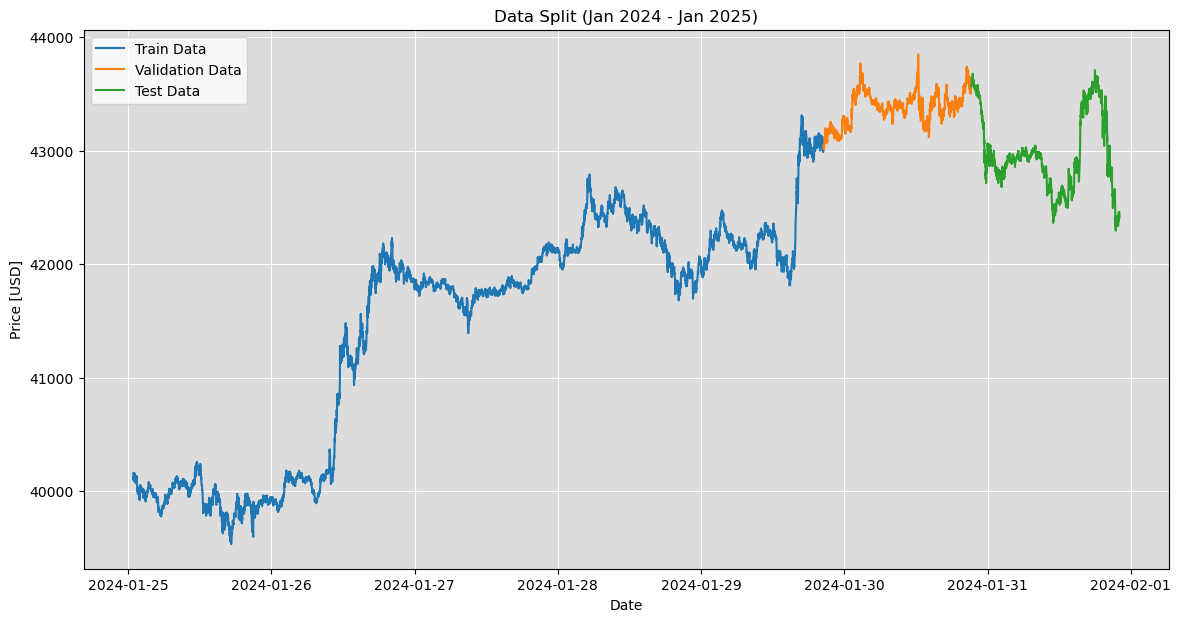

In [70]:
dates_train = btc_price_data_1_year_train.index
prices_close_train = btc_price_data_1_year_train.close

dates_val = btc_price_data_1_year_val.index
prices_close_val = btc_price_data_1_year_val.close

dates_test = btc_price_data_1_year_test.index
prices_close_test = btc_price_data_1_year_test.close

dates = [dates_train, dates_val, dates_test]
prices_close_btc = [prices_close_train, prices_close_val, prices_close_test]

title_btc = 'Data Split (Jan 2024 - Jan 2025)'

labels = ['Date', 'Price [USD]']

plot_splitted_market_data(dates, prices_close_btc, labels, title_btc)

### 9.2. Scale Features

1. Define the features to scale (numerical columns).
2. Fit the scaler on the **training set** only.
3. Apply the transformation to training, validation, and test sets.

In [71]:
# Exclude already normalized features like 'hour_sin'/'hour_cos'
features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
# Exclude already normalized features like 'hour_sin'/'hour_cos' and the 'target'('target' is categorical variable)
# features_to_exclude = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'target']

# Select the remaining columns
features_to_scale = [col for col in btc_price_data_1_year.columns if col not in features_to_exclude]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training set and transform all sets
btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
btc_price_data_1_year_val.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_val[features_to_scale])
btc_price_data_1_year_test.loc[:, features_to_scale] = scaler.transform(btc_price_data_1_year_test[features_to_scale])

C:\Users\valch\AppData\Local\Temp\ipykernel_10716\340430374.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.86956522 0.86956522 0.86956522]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
C:\Users\valch\AppData\Local\Temp\ipykernel_10716\340430374.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  btc_price_data_1_year_train.loc[:, features_to_scale] = scaler.fit_transform(btc_price_data_1_year_train[features_to_scale])
C:\Users\valch\AppData\Local\Temp\ipykernel_10716\340430374.py:13: FutureWarning: Setting an item of inco

### 9.3. Prepare Features and Targets

Separate the features and target variables for our LSTM model.

In [72]:
# Define features and target
# not_scaled_features = [x for x in features_to_exclude if x != 'target']
# Remove the 'target' feature from 'features_to_scale'
features_to_scale_cleaned = [x for x in features_to_scale if x != 'target']

X_train = btc_price_data_1_year_train[features_to_scale_cleaned + features_to_exclude].values
y_train = btc_price_data_1_year_train['target'].values

X_val = btc_price_data_1_year_val[features_to_scale_cleaned + features_to_exclude].values
y_val = btc_price_data_1_year_val['target'].values

X_test = btc_price_data_1_year_test[features_to_scale_cleaned + features_to_exclude].values
y_test = btc_price_data_1_year_test['target'].values

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

KeyError: "['weekday_sin', 'weekday_cos'] not in index"

### 9.4. Reshape Data for LSTM

LSTMs require input data in the shape of `(samples, sequence_length, num_features)`. For time series data, you typically convert the flat features into sequences.

In [ ]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])  # Last `timesteps` rows
        y_seq.append(y[i])             # Corresponding target
    return np.array(X_seq), np.array(y_seq)

In [ ]:
# Define the number of timesteps (sequence length) for LSTM
timesteps = 50  # Using the last 50 hours to predict the target

# Create sequences for training, validation, and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, timesteps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, timesteps)

print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}, y_val_seq shape: {y_val_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")

## 10. Define Model Architecture

### 10.1. Model Definition

### **TODO** - create a model description
Let’s use a hybrid CNN + LSTM architecture for time-series forecasting.

In [ ]:
def build_model(sequence_length, num_features):
    # Input layer
    input_layer = Input(shape=(sequence_length, num_features))
    
    # CNN for feature extraction
    cnn_layer = Conv1D(filters = 32, kernel_size = 3, activation='relu')(input_layer)
    cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    # LSTM for temporal dependencies
    # lstm_layer = LSTM(64, return_sequences=False)(input_layer)

    # LSTM for temporal dependencies
    lstm_layer = LSTM(64, return_sequences=True)(input_layer)
    attention_output = Attention()([lstm_layer, lstm_layer])  # Self-attention mechanism
    lstm_output = Flatten()(attention_output)
    
    # Combine CNN and LSTM outputs
    combined = Concatenate()([cnn_layer, lstm_output])
    
    # Fully connected layers
    dense_layer = Dense(128, activation='relu')(combined)
    dense_layer = Dropout(0.2)(dense_layer)
    dense_layer = Dense(64, activation='relu')(dense_layer)

    # Output layer (regression)
    output_layer = Dense(1, activation='linear')(dense_layer)
    
    # Build and compile the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

In [ ]:
def build_model_classification(sequence_length, num_features):
    # LSTM Input
    lstm_input = Input(shape=(sequence_length, num_features))
    
    # LSTM Layers
    x = LSTM(64, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    
    # Fully Connected Layer
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    # Output Layer - Probability of Price Going Up
    output = Dense(1, activation="sigmoid")(x)  # Probability between 0 and 1
    
    # Define Model
    model = tf.keras.Model(inputs=lstm_input, outputs=output)
    
    # Compile Model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return model

### 10.2. Initialize the Model

In [ ]:
sequence_length = X_train_seq.shape[1]  # Length of the sequences (e.g., 24 hours)
num_features = X_train_seq.shape[2]  # Number of features in the dataset

model = build_model(sequence_length, num_features)
model.summary()

### 10.3. Train the Model

Set up training parameters and callbacks to monitor performance.

**Early Stopping** prevents overfitting by stopping training when the validation performance stops improving.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# EarlyStopping(monitor='val_loss', patience=20)

Save the best model

In [ ]:
filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'
# filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{accuracy:.4f}-{val_accuracy:.4f}.hdf5'
cp = ModelCheckpoint(f'{filepath}.keras', save_best_only = True)
#cp = ModelCheckpoint('model/model1.keras', save_best_only = True, monitor = "loss", mode = 'mean')

In [ ]:
# filepath = 'models/{epoch:02d}-{loss:.4f}-{val_loss:.4f}-{mae:.4f}-{val_mae:.4f}.hdf5'

# callbacks = [EarlyStopping(monitor='val_loss', patience=20),
#              ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

**Train the model** with your training data, using validation data to track performance.

In [ ]:
# history = model.fit(
#     X_train_seq, y_train_seq,
#     epochs = 2,  # You can adjust this
#     batch_size = 32,  # Experiment with batch sizes
#     validation_data=(X_val_seq, y_val_seq),
#     callbacks=[early_stopping, cp],
#     verbose=1
# )

In [ ]:
# # Load the best model
# model = load_model('model/model1.keras')

### 10.4. Evaluate the Model

Evaluate the model on the test set to see how well it generalizes.

In [ ]:
def plot_prictions(predictions, actual_values, labels):
    # Plot predictions 
    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label = labels[0])
    plt.plot(actual_values, label = labels[1])
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'{labels[0]} vs. {labels[1]}')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Evaluate with Test Data

In [ ]:
# Predictions on the test data
y_pred_test = model.predict(X_test_seq)

# Metrics
mse = mean_squared_error(y_test_seq, y_pred_test)
mae = mean_absolute_error(y_test_seq, y_pred_test)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
# # Evaluate performance (Classification)
# loss, accuracy = model.evaluate(X_test_seq, y_test_seq)
# print(f"Test Accuracy: {accuracy:.4f}")

# # Predict probabilities
# y_pred_prob_test = model.predict(X_test_seq)
# y_pred_test = (y_pred_prob_test > 0.5).astype(int)

In [ ]:
test_pred = y_pred_test.flatten()
y_pred_test = y_test_seq.flatten()

test_results = pd.DataFrame(data = {'Test Predictions': test_pred, 'Actuals': y_pred_test})
test_results

In [ ]:
test_results['Test Predictions'].value_counts()

In [ ]:
test_results['Actuals'].value_counts()

In [ ]:
# Plot the predictions
labels = ['Test Predictions', 'Actual Test Values']
plot_prictions(test_results['Test Predictions'][:10], test_results['Actuals'][:10], labels)

#### Evaluate with Validate Data

In [ ]:
# Predictions on the test data
y_pred_val = model.predict(X_val_seq)

# Metrics
mse = mean_squared_error(y_val_seq, y_pred_val)
mae = mean_absolute_error(y_val_seq, y_pred_val)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
val_pred = y_pred_val.flatten()
y_pred_val = y_val_seq.flatten()

val_results = pd.DataFrame(data = {'Test Predictions': val_pred, 'Actuals': y_pred_val})
val_results

In [ ]:
# Plot the predictions
labels = ['Validate Predictions', 'Actual Validate Values']
plot_prictions(val_results['Test Predictions'], val_results['Actuals'], labels)

#### Evaluate with Train Data

In [ ]:
# Predictions on the Train Data
y_pred_train = model.predict(X_train_seq)

# Metrics
mse_train = mean_squared_error(y_train_seq, y_pred_train)
mae_train = mean_absolute_error(y_train_seq, y_pred_train)

print(f"Mean Squared Error (MSE): {mse_train}")
print(f"Mean Absolute Error (MAE): {mae_train}")

In [ ]:
train_pred = y_pred_train.flatten()
y_pred_train = y_train_seq.flatten()

train_results = pd.DataFrame(data = {'Train Predictions': train_pred, 'Actuals': y_pred_train})
train_results

In [ ]:
# Plot the predictions
labels = ['Train Predictions', 'Actual Train Values']
plot_prictions(train_results['Train Predictions'], train_results['Actuals'], labels)

### 10.5. Forecast Future Prices

Once the model is trained, you can use it to forecast future prices.

In [ ]:
# Prepare a sequence of the last 24 hours
latest_sequence = X_test_seq[-1].reshape(1, sequence_length, num_features)

# Predict the next hour's price
next_price_scaled = model.predict(latest_sequence)
print(f"Predicted next price: {next_price_scaled[0][0]}")

# Prepare the input with the same number of features
predicted_full_features = np.zeros((1, 55))  # Assuming 55 features in the original scaler
predicted_full_features[:, -1] = next_price_scaled[0][0]  # Insert the predicted price

# Inverse transform
next_price_original_full = scaler.inverse_transform(predicted_full_features)

# Extract the original price
next_price_original = next_price_original_full[0, -1]
print(f"Predicted next price (original scale): {next_price_original}")

Here’s a step-by-step guide on how to use your prepared dataset for training a neural network and tuning hyperparameters:

---
### **Step 6: Hyperparameter Tuning**
To tune hyperparameters, you can use tools like **Keras Tuner** or manually adjust parameters in a structured way.

### Option 1: Grid Search (Manual)
Manually try different combinations of hyperparameters:
- **Number of filters in CNN (e.g., 16, 32, 64).**
- **LSTM units (e.g., 32, 64, 128).**
- **Batch size (e.g., 16, 32, 64).**
- **Learning rate (e.g., 0.001, 0.0001).**
- **Dropout rate (e.g., 0.2, 0.3, 0.4).**

Example:
```python
for filters in [16, 32, 64]:
    for lstm_units in [32, 64, 128]:
        model = build_model(sequence_length, num_features)
        print(f"Training with filters={filters}, lstm_units={lstm_units}")
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)
```

---

### Option 2: Keras Tuner (Automated)
Use **Keras Tuner** to automate hyperparameter tuning.

```python
import keras_tuner as kt

# Define a model-building function for Keras Tuner
def build_tuned_model(hp):
    input_layer = Input(shape=(sequence_length, num_features))
    
    # CNN
    cnn_layer = Conv1D(
        filters=hp.Int('filters', min_value=16, max_value=64, step=16), 
        kernel_size=3, activation='relu'
    )(input_layer)
    cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
    cnn_layer = Flatten()(cnn_layer)
    
    # LSTM
    lstm_layer = LSTM(
        units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), 
        return_sequences=False
    )(input_layer)
    
    # Combine
    combined = Concatenate()([cnn_layer, lstm_layer])
    dense_layer = Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64), 
        activation='relu'
    )(combined)
    dense_layer = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(dense_layer)
    output_layer = Dense(1, activation='linear')(dense_layer)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='mse',
        metrics=['mae']
    )
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_tuned_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='bitcoin_forecasting'
)

# Run the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")
```

---

### **Step 7: Save and Load the Model**
Save the best model for future use.

```python
# Save model
model.save('bitcoin_price_model.h5')

# Load model
from tensorflow.keras.models import load_model
model = load_model('bitcoin_price_model.h5')
```

---

### **Step 8: Forecast Future Prices**
Once the model is trained, you can use it to forecast future prices.

```python
# Prepare a sequence of the last 24 hours
latest_sequence = X_test[-1].reshape(1, sequence_length, num_features)

# Predict the next hour's price
next_price = model.predict(latest_sequence)
print(f"Predicted next price: {next_price[0][0]}")
```

---

This approach allows you to train, evaluate, and tune your model effectively. Let me know if you need more help!

## Resources

[1] Venujkvenk. (2023b, September 23). Exploring time series data: unveiling trends, seasonality, and residuals. Medium. https://medium.com/venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1

[2] Kis, A. (2024, November 19). Understanding autocorrelation and partial autocorrelation functions (ACF and PACF). Medium. https://medium.com/kis.andras.nandor/understanding-autocorrelation-and-partial-autocorrelation-functions-acf-and-pacf-2998e7e1bcb5

[3] Olamendy, J. C. (2025, January 17). Mastering feature scaling and normalization in machine learning. Medium. https://medium.com/juanc.olamendy/mastering-feature-scaling-and-normalization-in-machine-learning-985fdecfab5c

[4] Hamad, R. (2023, December 11). What is LSTM? Introduction to Long Short-Term Memory. Medium. https://medium.com/rebeen.jaff/what-is-lstm-introduction-to-long-short-term-memory-66bd3855b9ce